<a href="https://colab.research.google.com/github/itc202/praktik/blob/main/RECOGNITION_CATS_and_DOGS_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание кошек и собак

Для распознавания используется сверточная нейронная сеть.
Основное содержание:
- подключение архива данных
- просмотр содержания дата сета
- создание сверточной сети и ее просмотр
- компиляция сети
- создание генераторов изображений для тренировки и проверки
- обучение нейросети
- оценка качества и вывод графика
- сохранение модели нейросети (структуры и весов), в облако и на локальный компьютер
- загрузка модели нейросети (с новым названием)
- компиляция загруженной нейросети
- распознавание собственных  картинок (загрузка, просмотр, подготовка, классификация на нейросети)


Ноутбук создан с использованием материалов ноутбуков А.Созыкина (УрФУ), а также ноутбуков Виртуальной школы Сбербанка, лето 2020.



# Видео к ноутбуку

А.Созыкин
 - подготовка набора изображений в KERAS https://www.youtube.com/watch?v=_bH2oh75Kdo
 - сохранение и загрузка нейросети https://www.youtube.com/watch?v=ro3s22RyvbA
 - загрузка данных в Colab
https://www.youtube.com/watch?v=Ve5oW1qqbZg
- команды Linux (директории, файлы  и т.п.) https://www.youtube.com/watch?v=1Q_MF-IXzDQ


И другие видео  канала А.Созыкина

https://www.youtube.com/channel/UC5gufuYHPSsJA-jul-iwyXA


In [ ]:
# ИМпорт библиотек для работы с файловой системой
# для операций с файлами и каталогами (копирование, перемещение, создание, удаление)
import shutil
import os
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator #функция для загрузки картинок и генератор
from tensorflow.keras.models import Sequential #модели из библиотеке Керас
from tensorflow.keras.layers import Conv2D, MaxPooling2D #слои нейросети
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense



Вспомогательные функции

In [ ]:
from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

In [ ]:
def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))

    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

In [ ]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_height, img_width, 3)
# Количество эпох
#было первоначаль
epochs = 30
#epochs = 3
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 22500
# Количество изображений для проверки
nb_validation_samples = 2500
# Количество изображений для тестирования
nb_test_samples = 2500



# Набор данных
Набор данных берется по ссылке из интернета. Можно использовать другие наборы - указать иную ссылку, в том числе ссылку на размещение архива на гугл-диске
Набор данных организуется в виде архива, где есть главная директория и поддиректории для обучения и тестирования. В каждой из них - поддиректори  с кошками и собаками.


In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2023-07-15 05:32:58--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.248, 52.217.135.120, 52.217.13.6, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  5.03MB/s    in 62s     

2023-07-15 05:34:01 (8.88 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
base_dir = 'Cat_Dog_data'


train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

Cat_Dog_data/
|  test/
|  |  dog/
|  |  cat/
|  train/
|  |  dog/
|  |  cat/


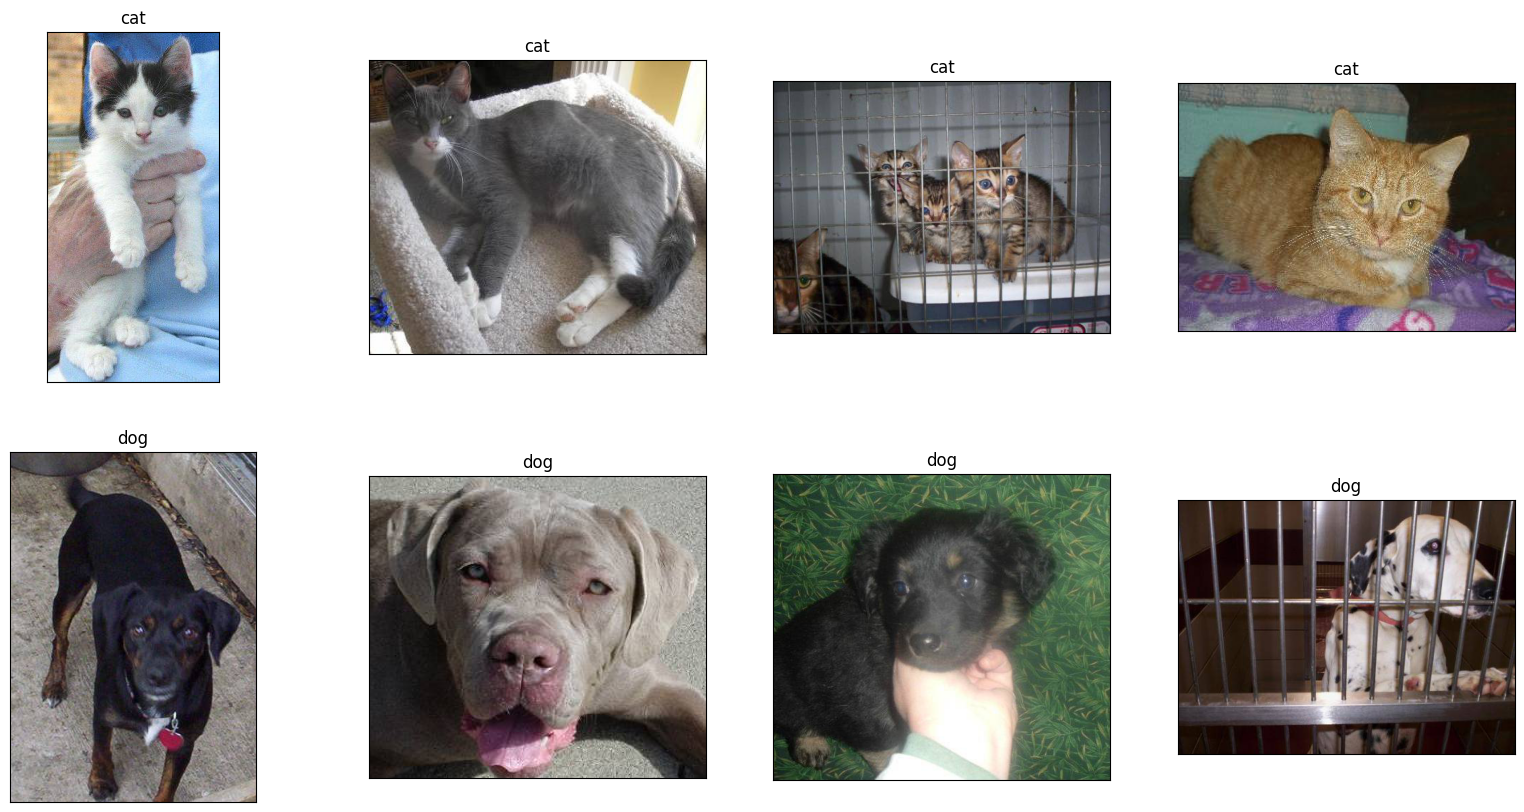

In [ ]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
plot_cats_dogs_samples(train_dir, N=4)


Создаем сверточную нейронную сеть¶

> Блок с отступами



Архитектура сети

    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 64 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    flatten - Слой преобразования из двумерного в одномерное представление
    Полносвязный слой, 64 нейрона, функция активации ReLU.
    Слой Dropout.
    Выходной слой, 1 нейрон, функция активации sigmoid

Слои с 1 по 6 используются для выделения важных признаков в изображении, а слои с 7 по 10 - для классификации.


In [ ]:
model = Sequential()
# Сверточный слой -активация - слой выделения признаков  (maxpooling)
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Сверточный слой -активация - слой выделения признаков  (maxpooling)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Сверточный слой -активация - слой выделения признаков  (maxpooling)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# Слой классифкатор  - активация - слой против переобучения (dropout) -
#решающий нейрон - сигмоидная активация
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))



далее посмотрим, что из себя представляет эта сеть


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

Расчет числа параметров в конвулятивной сети по Summary сети:
Число параметров - есть число межнейрнонных связей с предыдущим слоем (т.е. весов)
**для слоя dense**
можно вычислять как число нейронов в выхоной форме предыдущего слоя Х на число нейронов в данном слое + один на байес
пример: для слоя dence - 18496 Х 64 + 64 = 1183808

**ДЛя слоя conv2d**
размер ядра (в нашем случае 3х3 =9)
9хNxM+M - 9 - число нейронов в ядре свертки, N - число карт признаков на выходе в предыдущем слое, M - число карт признаков в данном слое, второй раз M  берется на ссещение (байас)

пример:

9х32х64 + 64 = 18496

Пример для расчета входа:
на входе 3 канала
на выходе первого слоя 32 карты признаков
размер ядра 3х3 =9
Расчет чимсла параметров (коэффициентов межнейронных связей)
9Х3Х32+32 = 896


In [ ]:
# комментария к SUMMARY сети: число параметров - есть число межнейрнонных связей с предыдущим слоем (т.е. весов)
# можно вычислять как число нейронов в выхоной форме предыдущего слоя Х на число нейронов в данном слое + один на байес
# пример: для слоя dence - 18496 Х 64 + 64 = 1183808

In [ ]:
# нарисовать граф модели с использованием функции Keras
# простой вариант (без вывода форм)
#  более сложный вариант - с выводом форм


Компилируем нейронную сеть

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога


In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 22500 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога


In [ ]:
test_generator = datagen.flow_from_directory(
    #val_dir,
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога


In [ ]:
#Обучаем модель
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
1406/1406 [==============================] - 98s 61ms/step - loss: 0.6478 - accuracy: 0.6109 - val_loss: 0.6145 - val_accuracy: 0.6474
Epoch 2/30
1406/1406 [==============================] - 82s 58ms/step - loss: 0.5290 - accuracy: 0.7384 - val_loss: 0.5428 - val_accuracy: 0.7123
Epoch 3/30
1406/1406 [==============================] - 79s 56ms/step - loss: 0.4724 - accuracy: 0.7772 - val_loss: 0.4895 - val_accuracy: 0.7756
Epoch 4/30
1406/1406 [==============================] - 84s 59ms/step - loss: 0.4171 - accuracy: 0.8119 - val_loss: 0.4606 - val_accuracy: 0.7833
Epoch 5/30
1406/1406 [==============================] - 84s 60ms/step - loss: 0.3636 - accuracy: 0.8408 - val_loss: 0.4631 - val_accuracy: 0.7881
Epoch 6/30
1406/1406 [==============================] - 84s 60ms/step - loss: 0.3179 - accuracy: 0.8633 - val_loss: 0.4153 - val_accuracy: 0.8169
Epoch 7/30
1406/1406 [==============================] - 84s 60ms/step - loss: 0.2754 - accuracy: 0.8806 - val_loss: 0.4572 -

Оцениваем качество работы сети с помощью генератора


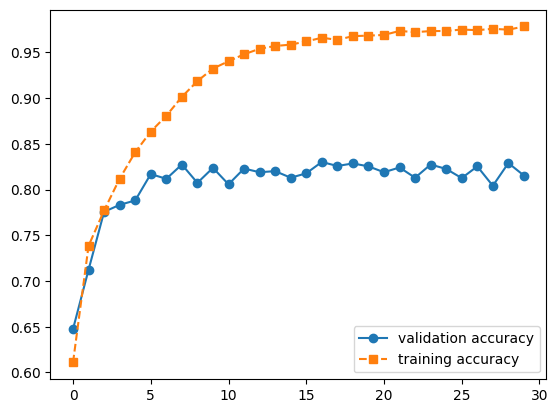

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

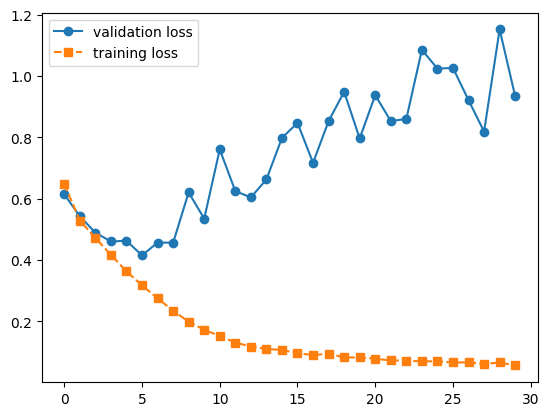

In [ ]:
# Построим изменение потерь на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [ ]:
# Взглянем на итоговые результаты классификации на тестовой выборке
# (функция ошибки, точность)
model.evaluate(test_generator)

157/157 [==============================] - 8s 48ms/step - loss: 0.4781 - accuracy: 0.7776


[0.4781224727630615, 0.7775999903678894]

Далее сохраним модель сети



Подробнее про сохранение и считывание модели - см. здесь https://blog.stroganov.pro/%D1%81%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9-%D1%81%D0%B5%D1%82%D0%B8/

Там же смотри подробнее про сохранение/считывание весов


Материалы Colab по внешним данным: https://colab.research.google.com/notebooks/io.ipynb

Внимание! Ниже показано сохранение с устаревшим способом. Нужно применит ьболее современный способ сохранения модели с помощью save

In [ ]:
print("Сохраняем сеть")
# Сохраняем сеть для последующего использования
# Генерируем описание модели в формате json
model_json = model.to_json()
json_file = open("CAT_and_DOG.json", "w")
# Записываем архитектуру сети в файл
json_file.write(model_json)
json_file.close()
# Записываем данные о весах в файл
model.save_weights("CAT_and_DOG.h5")
print("Сохранение сети завершено")

Сохраняем сеть
Сохранение сети завершено


In [ ]:
#вызов метода для работы с файлами (загрузки)
from google.colab import files


In [ ]:
#собственно сохранение
files.download("CAT_and_DOG.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#сохраняем веса сети
files.download("CAT_and_DOG.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Загружаем сохраненную сеть


In [ ]:
from keras.models import model_from_json

для загрузки файла используем - размещение файла на внешнем сайте или гугл.диске. В колабе используем команда !... от линукс. Во втором случае может потребоваться !gdown
If you use curl/wget, it fails with a large file because of the security warning from Google Drive.
Видимо, дело в не размере. Оказалось !wget тоже работает с гугл диска -  только он, похоже,  загружает  в колаб файл html с именем  "view?usp=sharing" (это окончание ссылки на файл на гугл.диске)

In [ ]:
#загрузка данныйх нейросети из файла
#!wget Здесь нужно прописать адрес созраненных данных на внешнем сайте https://.....

In [ ]:
#!wget http://

In [ ]:
!ls

CAT_and_DOG.h5	  Cat_Dog_data	    __MACOSX
CAT_and_DOG.json  Cat_Dog_data.zip  sample_data


In [ ]:
#!head Указать имя файла для просмотра просмотр сохраненной нейросети, нужно вписать название файла по факту
!head CAT_and_DOG.json


{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation", "trainable": true, "dtype": "float32", "activation": "relu"}}, {"class_name": "MaxPooling2D", "config

In [ ]:
#!head CAT_and_DOG.h5

In [ ]:
print("Загружаю сеть из файлов")
# Загружаем данные об архитектуре сети
json_file = open("CAT_and_DOG.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель
loaded_model = model_from_json(loaded_model_json)
# Загружаем сохраненные веса в модель
loaded_model.load_weights("CAT_and_DOG.h5")
print("Загрузка сети завершена")

Загружаю сеть из файлов
Загрузка сети завершена


Далее мы можем проводить с переменной loaded_model все процедуры, обучать, прогнозировать, но сначала ее нужно скмопилировать, т.е.  вызвать ее метод compile.

In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Взглянем на итоговые результаты классификации этой загруженной модели на тестовой выборке
# (функция ошибки, точность). Она по идее совпадает со значениями ранее оубченной и сохраненной сети
loaded_model.evaluate(test_generator)

157/157 [==============================] - 7s 45ms/step - loss: 0.9673 - accuracy: 0.8476


[0.9672772288322449, 0.847599983215332]

Распознавание своего изображения



Дополнительно см. материалы ноутбуков А. Созыкина
 https://colab.research.google.com/drive/1K3Pn8aXM06hUfhn241y8UIGQ_xcHKF8n#scrollTo=44DYnv7NJ9M9


In [ ]:
from IPython.display import Image
from tensorflow.keras.preprocessing import image

про загрузку изображений см здесь:
https://www.youtube.com/watch?v=Ve5oW1qqbZg


In [ ]:
#если выше не было этого вызова вызов метода для работы с файлами (загрузки)
from google.colab import files

In [ ]:
f = files.upload()


Saving dog_Proba.JPG to dog_Proba.JPG


In [ ]:
#смотрим, что есть в облачном хранилище, есть ли там наша картинка
!ls


Cat_Dog_data  Cat_Dog_data.zip	dog_Proba.JPG  __MACOSX  sample_data


In [ ]:
# если хочется посмотреть текущйи каталог]
!pwd



/content


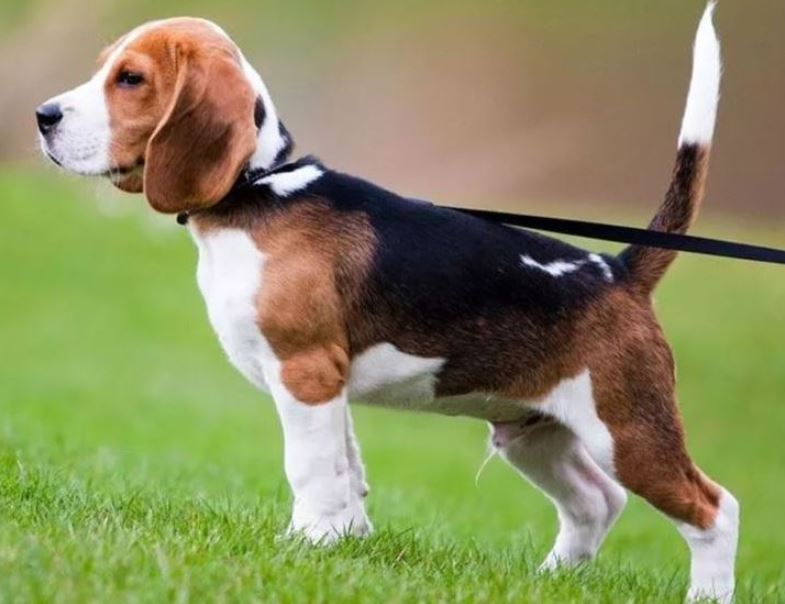

In [ ]:
#Покажем файл в облачном хранилище
Image ('dog_Proba.JPG')

In [ ]:
img_path = 'dog_Proba.JPG'

In [ ]:
# Преобразуем картинку в вектор , массив numpy
Image(img_path, width=150, height=150)
import numpy as np
#устанавливаем целевой размер, как и ранее при обучении - 150 на 150
img = image.load_img(img_path, target_size=(150, 150), grayscale=False)
# Преобразуем изображением в массив numpy
x = image.img_to_array(img)
x = 255 - x
x /= 255
x = np.expand_dims(x, axis=0)


In [ ]:
#Распознавание с помощью исходной нейросети (которая не загружалась)
prediction = model.predict(x)
print (prediction)

1/1 [==============================] - 0s 208ms/step
[[0.9986526]]


Распознавание изображения
с помощью модели загруженной с компьютера нейросети


In [ ]:
prediction = loaded_model.predict(x)
print (prediction)


1/1 [==============================] - 0s 66ms/step
[[0.97606796]]


In [ ]:
prediction


array([[0.97606796]], dtype=float32)

In [ ]:
#bbb = np.argmax(prediction) - это возврат значения индекса наибольшего значения в массиве,  унас всегда одно значение
bbb = np.around(prediction, decimals=0)
print (bbb[0])
print("Номер класса:", bbb)
#print("Название класса:", classes[prediction])

[0.]
Номер класса: [[0.]]


Задание:
1) Получить доступ к внутренним слоям обученной модели
2) Вывести на экран изображения карт признаков для выбранных внутренних слоев

Проба: доступ к промежуточным слоям оубченной модели.
Нужно сделать отдельные модели для каждого из интересующих слоев. (со своим аутпутом)
- Сделать предсказание каждой из этих моделей - в переменную вида prediction.
- Посмотреть форму тензора на выходе этих моделей (вывести на экран).
- Далее вывести этот тензор (массив числе) преобразовать в изображение и вывести на экран (использовать вспомогательные библиотеки Pil, openCV  и др.)

In [ ]:
#Попробуем получить доступ к внутренним слоям модели
from keras.models import Model
# Имя слоя берется из Summury нейросети
model2= Model(model.input,model.get_layer('conv2d_2').output)
#model2= Model(model.input,model.layers[1].output)

In [ ]:
preds=model2.predict(x)

1/1 [==============================] - 0s 116ms/step


In [ ]:
np.shape(preds)

(1, 34, 34, 64)

In [ ]:
preds_a=preds[0,:,:,:]

In [ ]:
np.shape(preds_a)

(34, 34, 64)

In [ ]:
model3= Model(model.input,model.get_layer('max_pooling2d_2').output)

In [ ]:
preds3=model3.predict(x)

1/1 [==============================] - 0s 53ms/step


In [ ]:
np.shape(preds3)

(1, 17, 17, 64)

In [ ]:
preds3_a=preds3[0,:,:]

In [ ]:
np.shape(preds3_a)

(17, 17, 64)

In [ ]:
prob_img=preds3_a[:,:]


In [ ]:
np.shape(prob_img[:,:,:1])

(17, 17, 1)

In [ ]:
# вывод изображения из массива - использовать преобразование image.fromarray

Выше мы определили prediction. Если это просто картинка-массив Высота х Ширина, то работает - выводится одно изображение размером этой Высоты и Ширины. Если же это тензор - много таких массивов, то они все накладываются в плоское изображение такой же Высоты и ширины

Пробуем , что будет после после функции активации. То есть в качестве аутпута модели ставим слой после активации 'activation'

In [ ]:
model4= Model(model.input,model.get_layer('activation').output)
preds4=model4.predict(x)
preds4_a=preds4[0,:,:]
np.shape(preds4_a)


1/1 [==============================] - 0s 68ms/step


(148, 148, 32)

In [ ]:
# с помощью библиотек (PIL  и т.п.) попробовать изменять размеры изображения